In [4]:
import functools
import numpy as np
from beam.system import System
from beam import mesh
from beam import postprocessing as postproc
import matplotlib.pyplot as plt

In [9]:
def case():
    """
    In this example, one cantilever beam is bent towards another.
    Contact, static analysis.
    """
    
    mat = {
        'Area':7.85398e-5,
        'Elastic modulus':1.0e9,
        'Shear modulus':0.3846e9,
        'Inertia primary':4.90874e-10,
        'Inertia secondary':4.90874e-10,
        'Inertia torsion':9.81748e-10,
        'Shear coefficient primary':1.0,
        'Shear coefficient secondary':1.0,
        'Density':8.0e-7,
        'Contact radius':0.005
    }
    
    (coordinates1, elements1) = mesh.line_mesh(A=(0,0,0), B=(2.0,0,0), n_elements=3, order=1, material=mat, reference_vector=(0,0,1))
    (coordinates2, elements2) = mesh.line_mesh(A=(0.05,0,0.015), B=(0.85,0,0.015), n_elements=2, order=1, material=mat, reference_vector=(0,0,1),
                                               starting_node_index=coordinates1.shape[1], possible_contact_partners=elements1,
                                               dual_basis_functions=False, n_contact_integration_points=None)
    
    coordinates1[0,1] = 0.9
    coordinates1[0,2] = 1.2

    coordinates = np.hstack((coordinates1, coordinates2))
    elements = elements1 + elements2
    
    system = System(coordinates, elements)
    system.time_step = 1.0
    system.final_time = 101.0
    system.solver_type = 'static'
    system.convergence_test_type = 'RES'
    system.contact_detection = True
    system.printing = False
    system.max_number_of_newton_iterations = 10
    
    def user_distributed_force_load(self):
        q = []
        for ele in self.elements:
            qe = np.zeros((6, ele.int_pts[1].n_pts))
            p = 1.0
            qe[2] = -p
            q.append(qe)
        return q
    
    def user_displacement_load(self):
        n_nodes = self.get_number_of_nodes()
        U = np.zeros((6, n_nodes))
        if self.current_time > 1:
            U[0,coordinates1.shape[1]] = 1.001 / 100
        return U
        
    system.degrees_of_freedom[-1][0,coordinates1.shape[1]] = False  # [current time, dof 0 through 5, first node of the top beam]
    system.degrees_of_freedom[-1][6,coordinates1.shape[1]:] = True  # [current time, dof 6, all nodes of the top beam]
    system.degrees_of_freedom[-1][:6,:coordinates1.shape[1]] = False  # [current time, dof 0 through 5, all nodes of the bottom beam]
    system.distributed_force_load = functools.partial(user_distributed_force_load, system)
    system.displacement_load = functools.partial(user_displacement_load, system)
    
    return system

In [10]:
system = case()
system.solve()

In [11]:
gN = np.array(system.gap_function)
gE = [0.015]
for g in gN:
    gE.append(np.linalg.norm(g[:,1]))

Text(0, 0.5, '$g$')

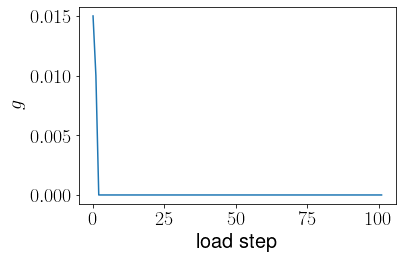

In [15]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 20
})
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(gE)
ax.set_xlabel('load step')
ax.set_ylabel("$g$")
#fig.savefig("img1.pdf", bbox_inches='tight')